##PROJECT METODE REKAYASA KOMPUTASIONAL
#####YUNIFAR SETYO RAHARJO_552357
#####ANNISA FAJRISIMA LISTYASARI_552594


Project ini dibuat untuk memenuhi tugas mata kuliah Metode Rekayasa Komputasional Program Magister Teknik Fisika
Project ini dikerjakan secara berkelompok oleh kelompok 4.

Menggunakan data Wind Turbine dengan Link Kaggle:
https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset

Data ini berisikan Data Wind Turbine selama 1 Tahun di Turkey.

Data diambil setiap 10 menit melalui SCADA System.

Data dapat digunakan sebagai baseline untuk feasibility study dalam pembangunan PLTB di suatu Lokasi. Machine Learning digunakan dalam memprediksi daya aktual yang akan dihasilkan di suatu lokasi apabila terdapat data kecepatan angin dan data teoritical power (kWh) yang dapat dihitung secara matematis. Feasibility Study dalam pembangunan PLTB sangat membantu baik dari segi teknis maupun ekonomi untuk mengetahui suatu lokasi yang memiliki potensi untuk dibangun PLTB.


A. Loading Python Libraries dan Meng-Upload Dataset

In [3]:
#Upload Files Data Wind Turbine
from google.colab import files

Wind_Dataset = files.upload()

Saving Wind Turbine Dataset.csv to Wind Turbine Dataset.csv


In [4]:
#import Library yang akan digunakan
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

B. Input Data Frame

In [5]:
#Membaca data Wind Turbine
df_wind = pd.read_csv('Wind Turbine Dataset.csv')
df_wind.head(10)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
5,01 01 2018 00:50,402.391998,5.604052,499.436385,264.578613
6,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605
7,01 01 2018 01:10,387.242188,5.306050,414.898179,257.949493
8,01 01 2018 01:20,463.651215,5.584629,493.677652,253.480698
9,01 01 2018 01:30,439.725708,5.523228,475.706783,258.723785


In [6]:
#Konversi Tanggal dan Cek Informasi Dataset
df_wind["Date/Time"] = pd.to_datetime(df_wind["Date/Time"], format="%d %m %Y %H:%M")

# Ekstraksi fitur waktu
df_wind["Year"] = df_wind["Date/Time"].dt.year
df_wind["Month"] = df_wind["Date/Time"].dt.month
df_wind["Day"] = df_wind["Date/Time"].dt.day
df_wind["Hour"] = df_wind["Date/Time"].dt.hour
df_wind["Minute"] = df_wind["Date/Time"].dt.minute

# Drop kolom Date/Time
df_wind.drop(columns=["Date/Time"], inplace=True)

print(df_wind.info())
print(df_wind.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
 4   Year                           50530 non-null  int32  
 5   Month                          50530 non-null  int32  
 6   Day                            50530 non-null  int32  
 7   Hour                           50530 non-null  int32  
 8   Minute                         50530 non-null  int32  
dtypes: float64(4), int32(5)
memory usage: 2.5 MB
None
       LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307

In [7]:
#Display Structure Data Frame
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
 4   Year                           50530 non-null  int32  
 5   Month                          50530 non-null  int32  
 6   Day                            50530 non-null  int32  
 7   Hour                           50530 non-null  int32  
 8   Minute                         50530 non-null  int32  
dtypes: float64(4), int32(5)
memory usage: 2.5 MB


In [8]:
# Cek jumlah nilai nol di setiap kolom
zero_values = (df_wind == 0).sum()
zero_values

,0
LV ActivePower (kW),10781
Wind Speed (m/s),10
Theoretical_Power_Curve (KWh),7749
Wind Direction (°),75
Year,0
Month,0
Day,0
Hour,2112
Minute,8422


###Cleaning Dataset

In [9]:
#Menghilangkan beberapa data yang tidak digunakan dalam analisis karena berpotensi mengurangi akurasi model

# Hapus data di mana Wind Speed = 0 atau Wind Direction = 0
df_wind = df_wind[(df_wind["Wind Speed (m/s)"] > 0) & (df_wind["Wind Direction (°)"] > 0)]

# Hapus data dengan Active Power = 0 hanya jika Wind Speed > 3 m/s (menghindari data saat turbin mati)
df_wind = df_wind[~((df_wind["Wind Speed (m/s)"] > 3) & (df_wind["LV ActivePower (kW)"] == 0))]

# Hapus data duplikat
df_wind = df_wind.drop_duplicates()

#menampilkan data
df_wind

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Year,Month,Day,Hour,Minute
0,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0
1,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10
2,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20
3,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30
4,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40
...,...,...,...,...,...,...,...,...,...
50525,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23,10
50526,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23,20
50527,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30
50528,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40


C. Visualisasi Data

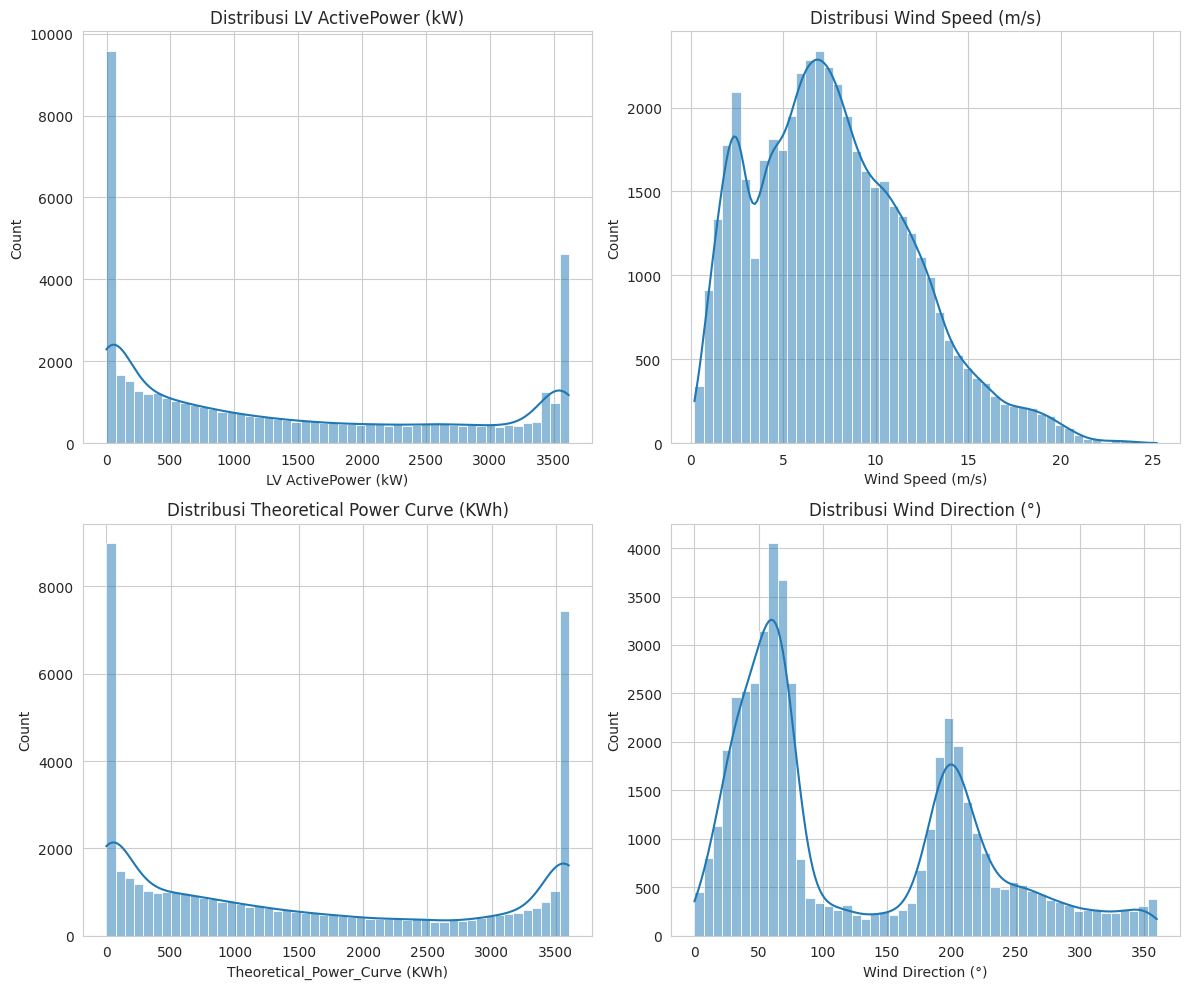

In [10]:
# Set style seaborn
sns.set_style("whitegrid")

# Plot distribusi fitur numerik
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(df_wind["LV ActivePower (kW)"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribusi LV ActivePower (kW)")

sns.histplot(df_wind["Wind Speed (m/s)"], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribusi Wind Speed (m/s)")

sns.histplot(df_wind["Theoretical_Power_Curve (KWh)"], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribusi Theoretical Power Curve (KWh)")

sns.histplot(df_wind["Wind Direction (°)"], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribusi Wind Direction (°)")

plt.tight_layout()
plt.show()

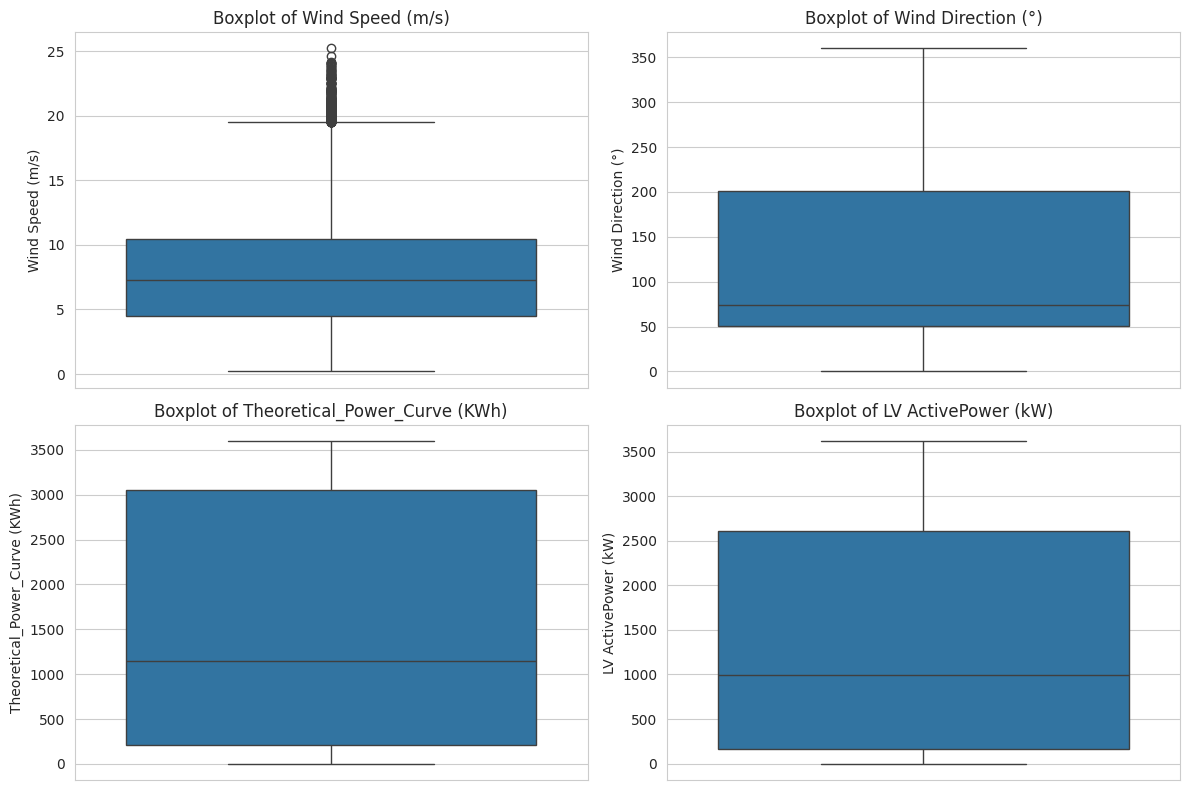

In [11]:
# Visualizing outliers using box plot, analisis statistik
plt.figure(figsize=(12, 8))
for i, col in enumerate(["Wind Speed (m/s)", "Wind Direction (°)", "Theoretical_Power_Curve (KWh)","LV ActivePower (kW)"]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df_wind[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [12]:
# Menangani outlier dengan IQR
Q1 = df_wind.quantile(0.25)
Q3 = df_wind.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_wind = df_wind[~((df_wind < lower_bound) | (df_wind > upper_bound)).any(axis=1)]
df_wind

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Year,Month,Day,Hour,Minute
0,380.047791,5.311336,416.328908,259.994904,2018,1,1,0,0
1,453.769196,5.672167,519.917511,268.641113,2018,1,1,0,10
2,306.376587,5.216037,390.900016,272.564789,2018,1,1,0,20
3,419.645905,5.659674,516.127569,271.258087,2018,1,1,0,30
4,380.650696,5.577941,491.702972,265.674286,2018,1,1,0,40
...,...,...,...,...,...,...,...,...,...
50525,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23,10
50526,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23,20
50527,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23,30
50528,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23,40


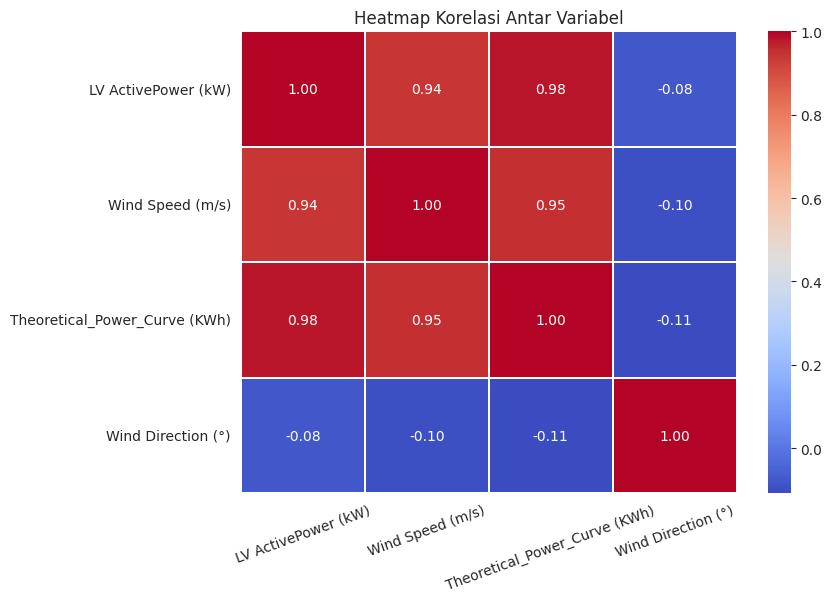

In [13]:
#Membuat Hubungan Korelasi Antar Variabel Berbasis Heatmap Untuk Data Numeric
numeric_df = df_wind.drop(columns=["Year", "Month", "Day", "Hour", "Minute"])
numeric_df_ = numeric_df.select_dtypes(include=[np.number]) #seluruh data numeric
if numeric_df_.shape[1] > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.2)
    plt.xticks(rotation=20)
    plt.title("Heatmap Korelasi Antar Variabel")
    plt.show()

<Figure size 1000x1000 with 0 Axes>

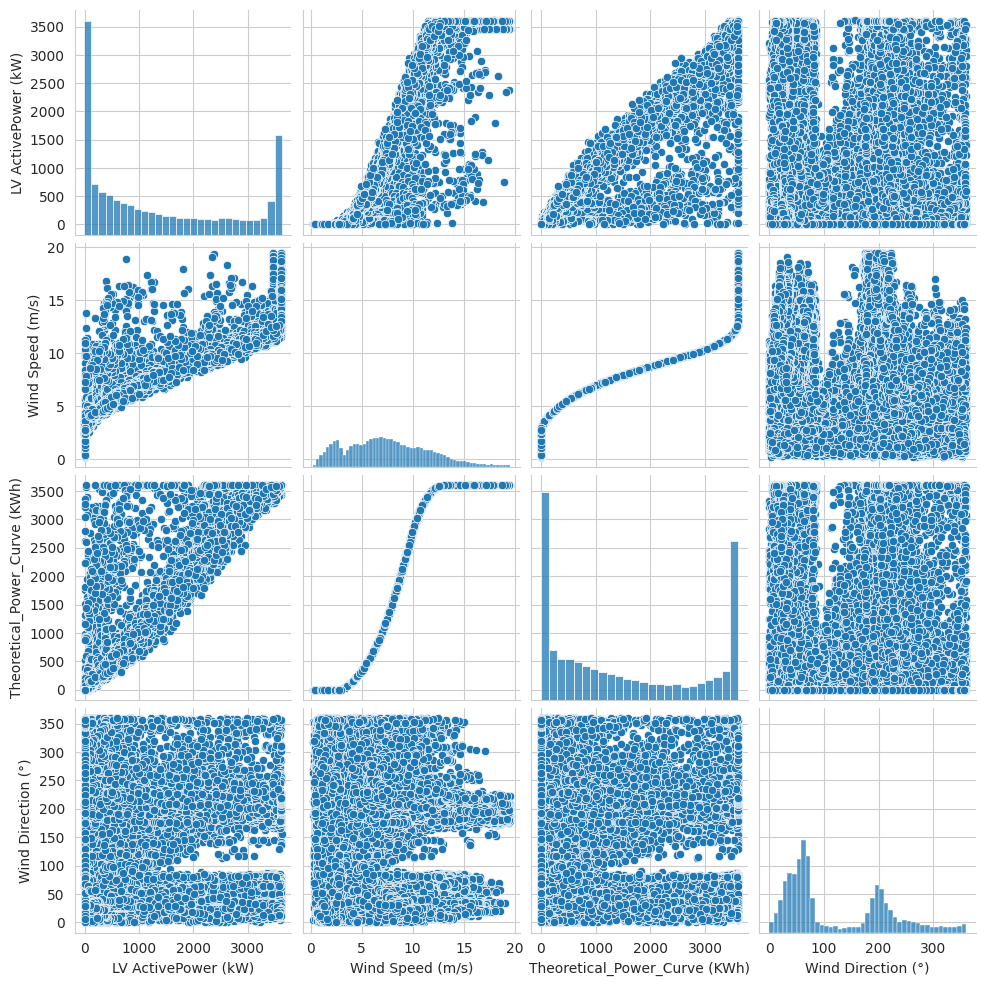

In [14]:
#Melihat hubungan antara variabel data yang ada menggunakan PairPlot
plt.figure(figsize = (10,10))
sns.pairplot(df_wind.drop(columns=["Year", "Month", "Day", "Hour", "Minute"]))
plt.show()

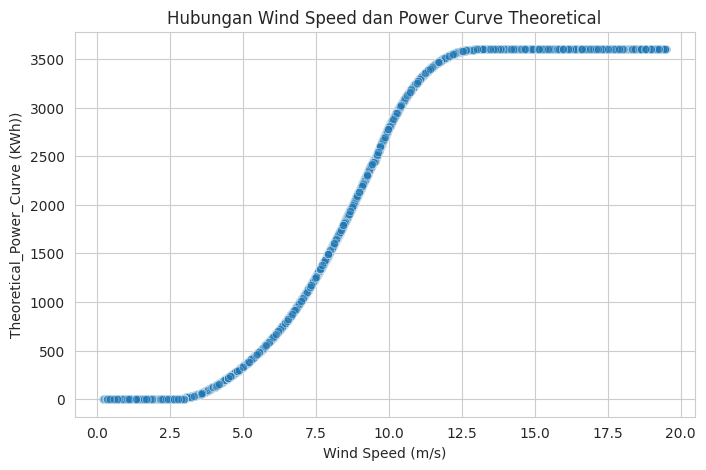

In [15]:
#Scatter Plot Wind Speed vs Power
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_wind["Wind Speed (m/s)"], y=df_wind["Theoretical_Power_Curve (KWh)"], alpha=0.5)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Theoretical_Power_Curve (KWh))")
plt.title("Hubungan Wind Speed dan Power Curve Theoretical")
plt.show()

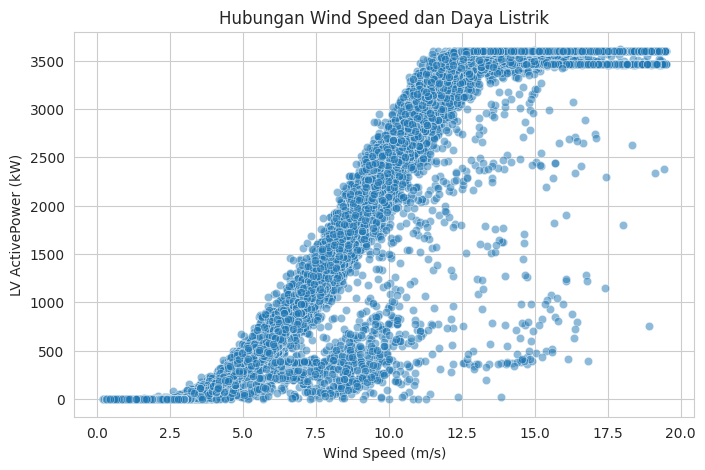

In [16]:
#Scatter Plot Wind Speed vs Power
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_wind["Wind Speed (m/s)"], y=df_wind["LV ActivePower (kW)"], alpha=0.5)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("LV ActivePower (kW)")
plt.title("Hubungan Wind Speed dan Daya Listrik")
plt.show()

Persiapan dataset ini menyatakan bahwa data tidak memiliki NaN value. Hal ini dapat dilihat pada heatmap atau pairplot diatas, sehingga dataset ini siap diolah atau dianalisis.

##MACHINE LEARNING
Pada hal ini, kami menggunakan metode Linear Regression yang diadopsi dari library Skicit-Learn.
Kami membandingkan hasil dari Linear Regression sebelum dan sesudah menggunakan Normalisasi (Standard Scaler). Stadandard Scaler adalah Algoritme cepat dan khusus untuk penskalaan data. Algoritme ini menghitung nilai rata-rata dan simpangan baku dari kumpulan data dan menormalkannya dengan mengurangi nilai rata-rata dan membaginya dengan simpangan baku.

###DATA PREPARATION

In [17]:
#Data untuk Machine Learning, features selection
features = ["Wind Speed (m/s)", "Wind Direction (°)", "Theoretical_Power_Curve (KWh)","Year","Month","Day","Hour","Minute"] #Sebagai Inputan
target = "LV ActivePower (kW)" #Sebagai Prediksi
X = df_wind[features]
y = df_wind[target]

In [18]:
#Splitting Data Train-Test dengan Test_size 20%
#Test Size 20% menggunakan data 20% data set untuk test, sedangkan 80%datanya digunakan sebagai training Modelnya
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###MODEL MACHINE LEARNING YANG DIGUNAKAN

In [19]:
#Menggunakan normalisasi
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [20]:
# Transformasi Power untuk mengatasi distribusi skewed
power_transformer = PowerTransformer()
X_train = power_transformer.fit_transform(X_train)
X_test = power_transformer.transform(X_test)

In [21]:
#Training Linear Regression Model
LR = LinearRegression() #
LR.fit(X_train, y_train)

# Hyperparameter tuning Untuk Metode Random Forest Regression dan Gradient Bosting Regression
"Hyperparameter Tuning ini digunakan untuk membuat model yang memiliki best prediction"
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [5, 10], 'min_samples_split': [2, 4]}
param_grid_gb = {'n_estimators': [50, 80], 'learning_rate': [0.1, 0.01], 'max_depth': [5, 20]}
param_grid_ada = {'n_estimators': [50,80], 'learning_rate': [0.1, 0.01]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf,cv=5, scoring="r2", n_jobs=-1)
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring="r2", n_jobs=-1)
ada_grid = GridSearchCV(AdaBoostRegressor(random_state=42), param_grid_ada,cv=5, scoring="r2", n_jobs=-1)
#Training Machine Learning Untuk Random Forest dan Gradient Boosting Regression
rf_grid.fit(X_train, y_train)
gb_grid.fit(X_train, y_train)
ada_grid.fit(X_train, y_train)

#Memilih Model yang paling Bagus
best_rf = rf_grid.best_estimator_
best_gb = gb_grid.best_estimator_
best_ada = ada_grid.best_estimator_

#Membuat definisi baru
RF = best_rf
RGB = best_gb
ADA = best_ada

In [22]:
print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best parameters for Gradient Boosting:", gb_grid.best_params_)
print("Best parameters for AdaBoost:", ada_grid.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}
Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 50}


In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_cv_score = np.mean(cv_scores)

    return {"Model": model.__class__.__name__, "MAE": mae, "MSE": mse,"RMSE": rmse, "R2": r2, "Cross Validation Score":mean_cv_score}, y_pred

In [24]:
#Mengevaluasi Masing-Masing Model yang dibangun
lin_results, y_pred_lin = evaluate_model(LR, X_test, y_test)
rf_results, y_pred_rf = evaluate_model(RF, X_test, y_test)
rgb_results, y_pred_rgb = evaluate_model(RGB, X_test, y_test)
ada_results, y_pred_ada = evaluate_model(ADA, X_test, y_test)

In [25]:
# Cetak hasil evaluasi untuk Linear Regression
print("\n=== Linear Regression Result ===")
for key, value in lin_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric

# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Random Forest Result ===")
for key, value in rf_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Gradient Bosting Regression Result ===")
for key, value in rgb_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk ADABOOST Regression
print("\n=== adaBoost Regression Result ===")
for key, value in ada_results.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric


=== Linear Regression Result ===
Model: LinearRegression
MAE: 0.1679
MSE: 0.0576
RMSE: 0.2400
R2: 0.9415
Cross Validation Score: 0.9390

=== Random Forest Result ===
Model: RandomForestRegressor
MAE: 0.0571
MSE: 0.0161
RMSE: 0.1268
R2: 0.9837
Cross Validation Score: 0.9832

=== Gradient Bosting Regression Result ===
Model: GradientBoostingRegressor
MAE: 0.0521
MSE: 0.0127
RMSE: 0.1125
R2: 0.9871
Cross Validation Score: 0.9869

=== adaBoost Regression Result ===
Model: AdaBoostRegressor
MAE: 0.1162
MSE: 0.0402
RMSE: 0.2006
R2: 0.9591
Cross Validation Score: 0.9568


In [26]:
# Membuat tabel hasil
results_df = pd.DataFrame([lin_results, rf_results, rgb_results, ada_results])
print(results_df)

                       Model       MAE       MSE      RMSE        R2  \
0           LinearRegression  0.167871  0.057601  0.240002  0.941468   
1      RandomForestRegressor  0.057146  0.016074  0.126782  0.983666   
2  GradientBoostingRegressor  0.052126  0.012654  0.112488  0.987142   
3          AdaBoostRegressor  0.116158  0.040245  0.200611  0.959104   

   Cross Validation Score  
0                0.939021  
1                0.983221  
2                0.986872  
3                0.956806  


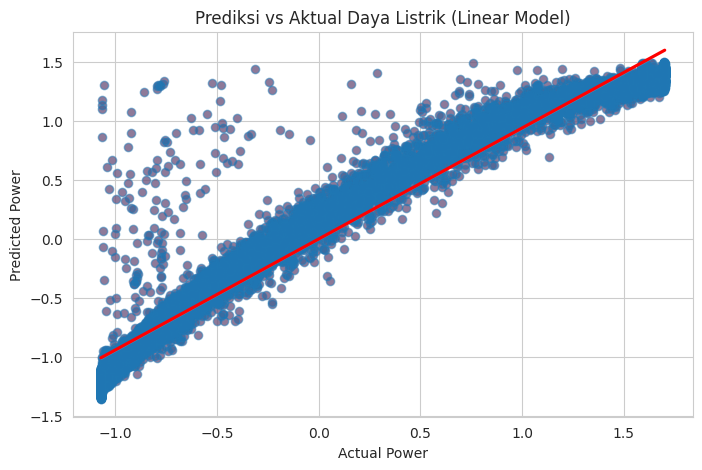

In [27]:
#Plot Linear Model
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_lin, alpha=0.5, color='red')
sns.regplot(x=y_test, y=y_pred_lin, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Linear Model)")
plt.show()

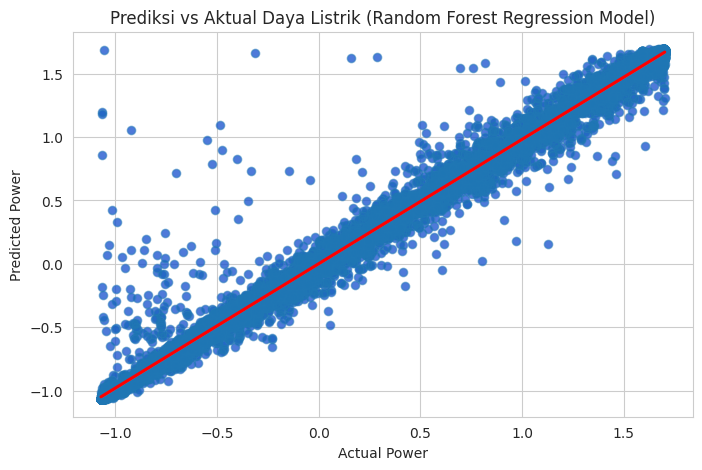

In [28]:
#Plot untuk Random Forest Regressor
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color='blue')
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Random Forest Regression Model)")
plt.show()

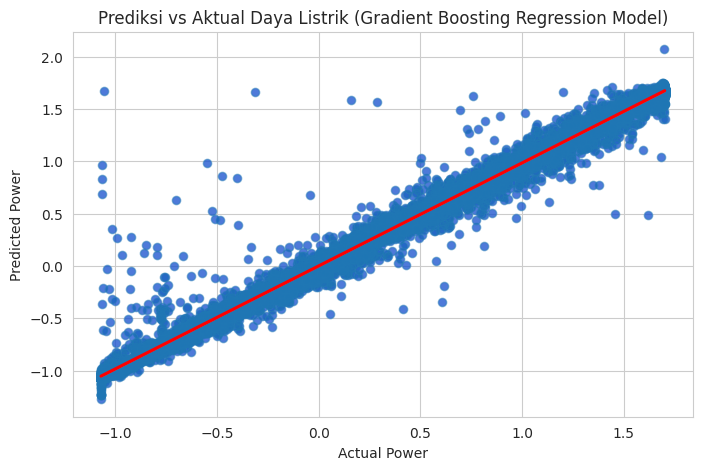

In [29]:
#Plot untuk Gradient Boosting Regressor
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_rgb, alpha=0.5, color='blue')
sns.regplot(x=y_test, y=y_pred_rgb, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Gradient Boosting Regression Model)")
plt.show()

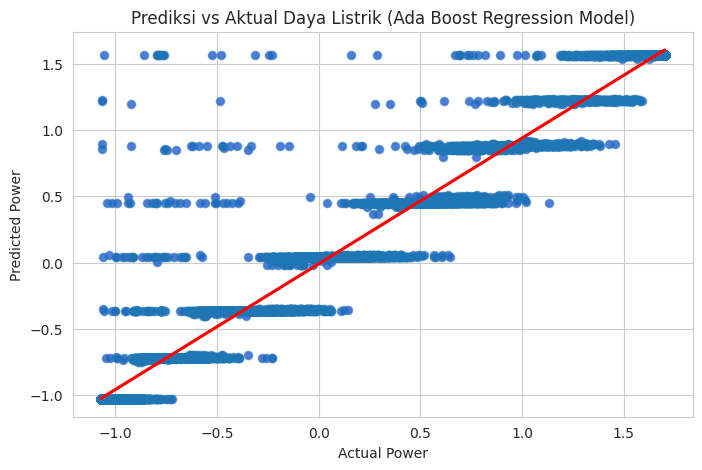

In [30]:
#Plot untuk Ada Boost Regression
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_ada, alpha=0.5, color='blue')
sns.regplot(x=y_test, y=y_pred_ada, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Prediksi vs Aktual Daya Listrik (Ada Boost Regression Model)")
plt.show()

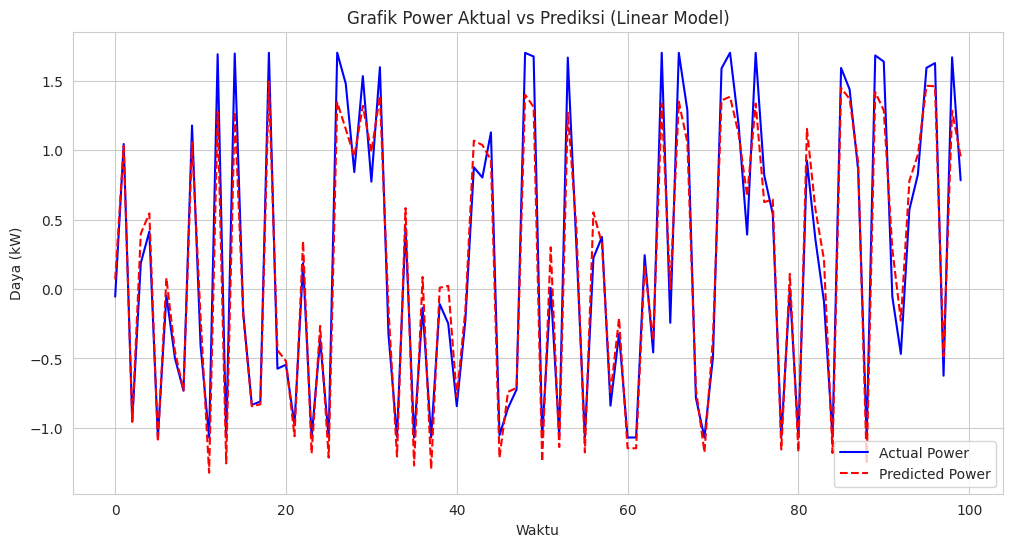

In [31]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_lin[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (Linear Model)")
plt.legend()
plt.show()


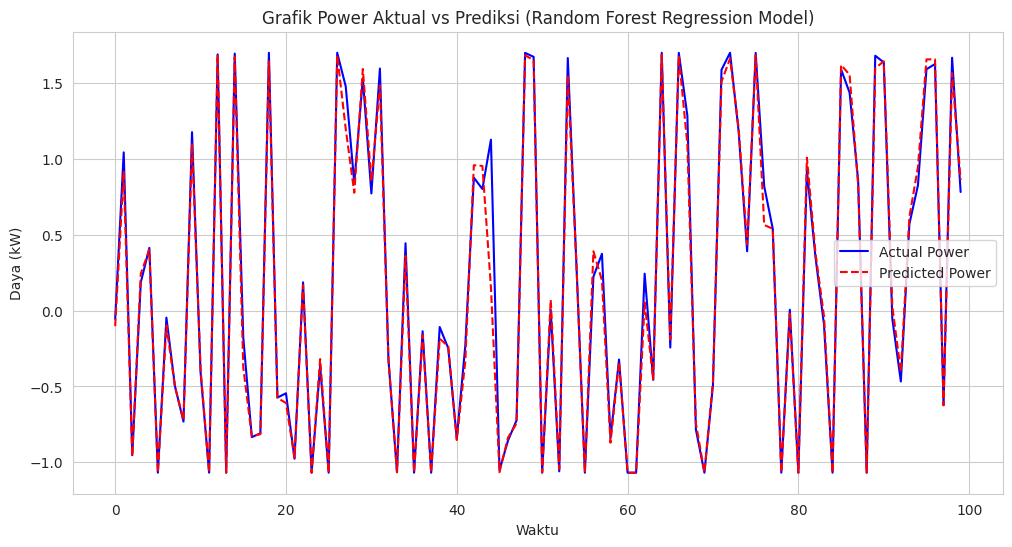

In [32]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_rf[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (Random Forest Regression Model)")
plt.legend()
plt.show()


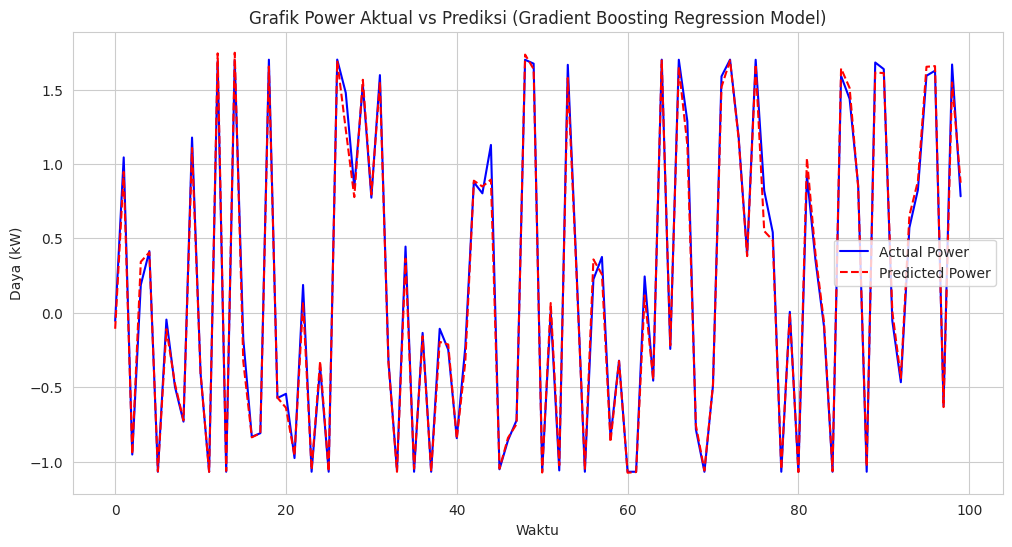

In [33]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_rgb[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (Gradient Boosting Regression Model)")
plt.legend()
plt.show()


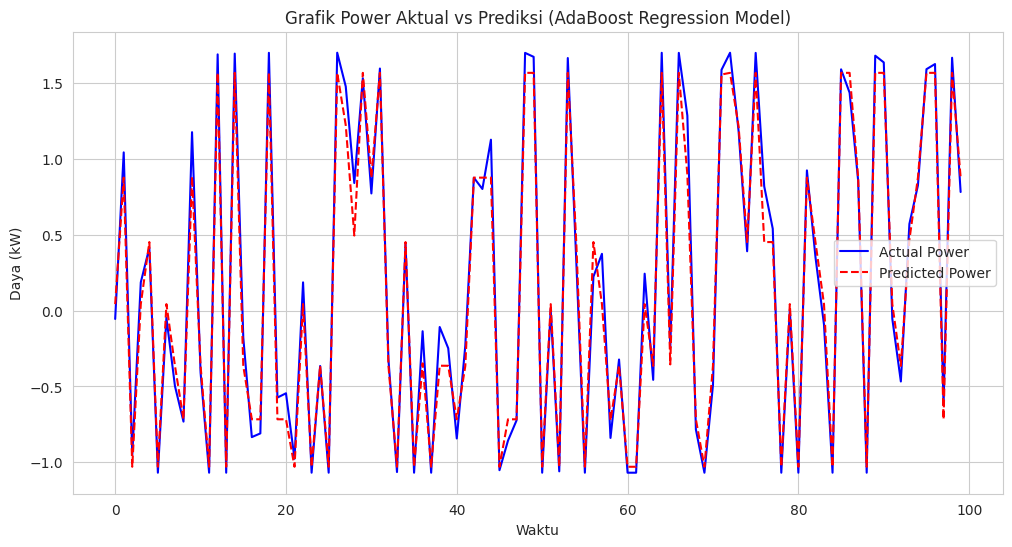

In [34]:
#Grafik Power Aktual vs Prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Power", color='blue')
plt.plot(y_pred_ada[:100], label="Predicted Power", color='red', linestyle='dashed')
plt.xlabel("Waktu")
plt.ylabel("Daya (kW)")
plt.title("Grafik Power Aktual vs Prediksi (AdaBoost Regression Model)")
plt.legend()
plt.show()


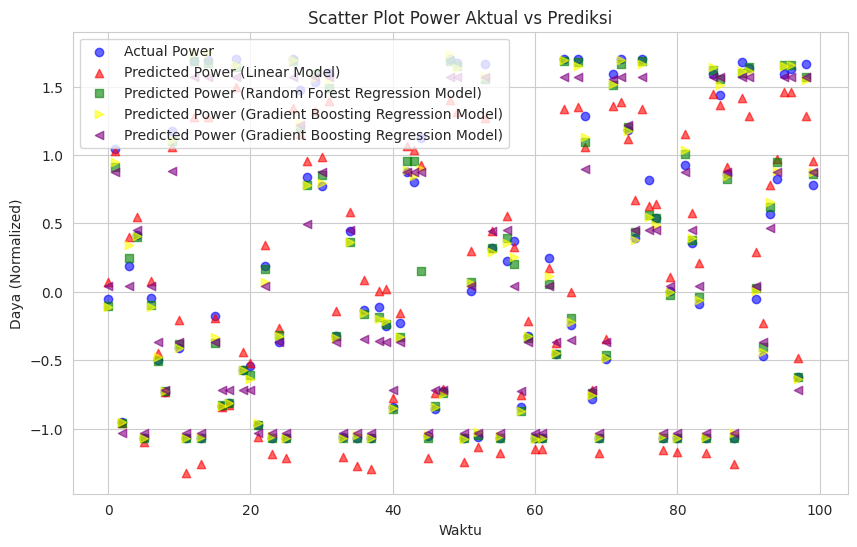

In [35]:
#Scatter Plot untuk Prediksi
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="Actual Power", color='blue', marker='o', alpha=0.6)
plt.scatter(range(len(y_pred_lin[:100])), y_pred_lin[:100], label="Predicted Power (Linear Model)", color='red', marker='^', alpha=0.6) # Changed y_pred to y_pred_lin
plt.scatter(range(len(y_pred_rf[:100])), y_pred_rf[:100], label="Predicted Power (Random Forest Regression Model)", color='green', marker='s', alpha=0.6) # Changed y_pred to y_pred_rf
plt.scatter(range(len(y_pred_rgb[:100])), y_pred_rgb[:100], label="Predicted Power (Gradient Boosting Regression Model)", color='yellow', marker='>', alpha=0.6) # Changed y_pred to y_pred_rgb
plt.scatter(range(len(y_pred_ada[:100])), y_pred_ada[:100], label="Predicted Power (Gradient Boosting Regression Model)", color='purple', marker='<', alpha=0.6)
plt.xlabel("Waktu")
plt.ylabel("Daya (Normalized)")
plt.title("Scatter Plot Power Aktual vs Prediksi")
plt.legend()
plt.show()

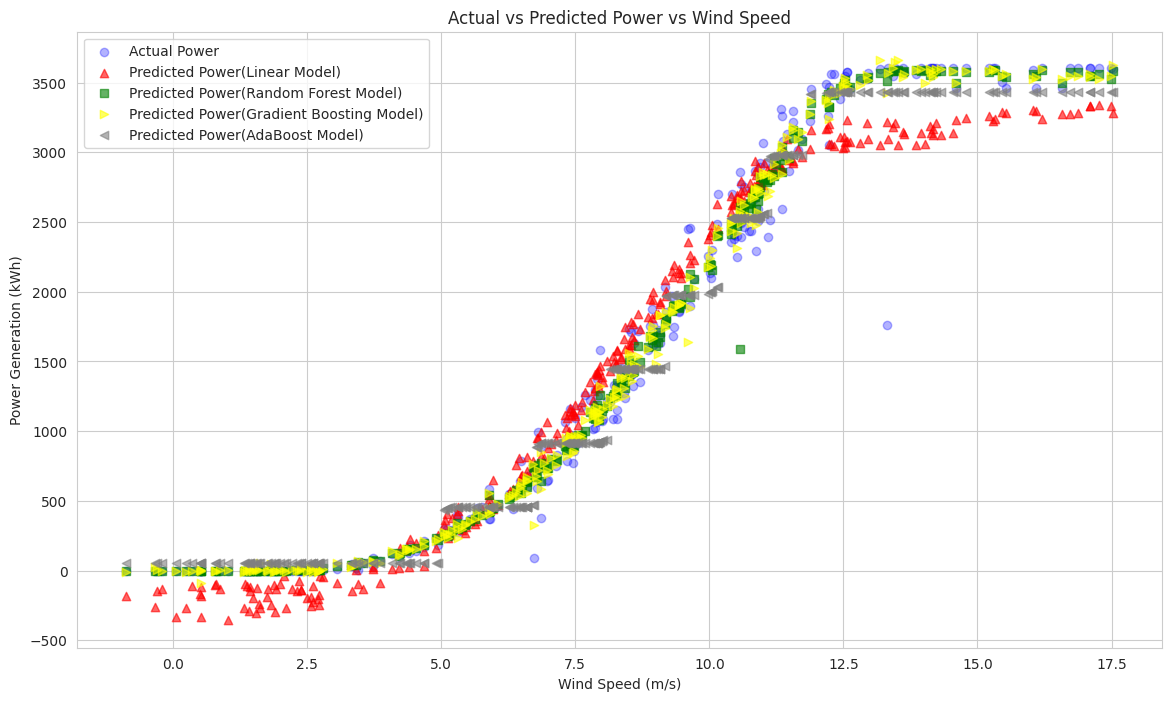

In [36]:
#memplot hasil dari prediksi power dan wind speed setelah data di-denormalisasikan.
plt.figure(figsize=(14, 8))
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_test[:300].reshape(-1, 1)), label="Actual Power", color='blue',marker='o', alpha=0.3)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_lin[:300].reshape(-1, 1)), label="Predicted Power(Linear Model)", color='red',marker='^', alpha=0.6)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_rf[:300].reshape(-1, 1)), label="Predicted Power(Random Forest Model)",color='green',marker='s', alpha=0.6)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_rgb[:300].reshape(-1, 1)), label="Predicted Power(Gradient Boosting Model)",color='yellow',marker='>', alpha=0.6)
plt.scatter(scaler_X.inverse_transform(X_test)[:300, 0], scaler_y.inverse_transform(y_pred_ada[:300].reshape(-1, 1)), label="Predicted Power(AdaBoost Model)",color='grey',marker='<', alpha=0.6)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Generation (kWh)")
plt.title("Actual vs Predicted Power vs Wind Speed")
plt.legend()
plt.show()

In [37]:
# Memilih Best Model dari nilai R-Square
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = [best_model_name]
best_model

['GradientBoostingRegressor']

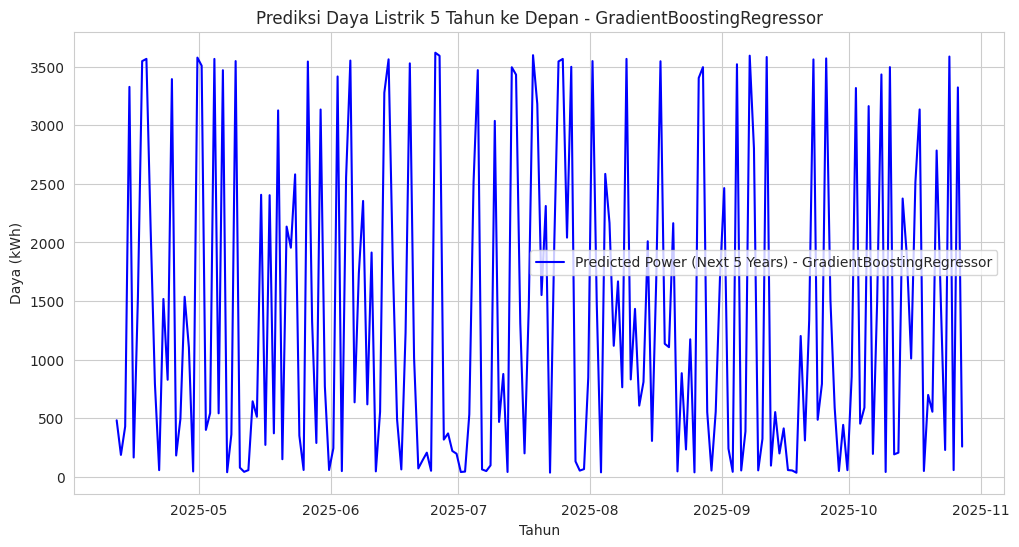

In [38]:
# Prediksi Untuk 5 Tahun Kedepan
years_future = 5
dates_future = pd.date_range(start=pd.Timestamp.now(), periods=years_future*365*24//10, freq='D')
X_future = X.sample(len(dates_future), replace=True).reset_index(drop=True)
X_future = scaler_X.transform(X_future)
y_future = RGB.predict(X_future)
y_future = scaler_y.inverse_transform(y_future.reshape(-1, 1)).ravel()

# Visualisasi untuk hasil Prediksi menggunakan Gradient Boosting Regressor
plt.figure(figsize=(12, 6))
plt.plot(dates_future[:200], y_future[:200], label=f"Predicted Power (Next 5 Years) - {best_model_name}", color='blue') #menampilkan 200 data Pertama
plt.xlabel("Tahun")
plt.ylabel("Daya (kWh)")
plt.title(f"Prediksi Daya Listrik 5 Tahun ke Depan - {best_model_name}")
plt.legend()
plt.show()

In [46]:
#MEMBUAT TESTING DATA BARU UNTUK MODEL YANG TELAH DIBANGUN DENGAN CARA INTERPOLASI DATASET YANG SUDAH DIGUNAKAN
# Interpolasi ke interval 5 menit
df_wind_2 = pd.read_csv('Wind Turbine Dataset.csv')
df_wind_2["Date/Time"] = pd.to_datetime(df_wind_2["Date/Time"], format="%d %m %Y %H:%M")

#Jadikan Date/Time sebagai index
df_wind_2.set_index("Date/Time", inplace=True)

#Interpolasi setiap 5 menit
df_interpolated = df_wind_2.resample("5T").interpolate(method="linear")

# Ambil 100000 sampel acak sebagai data test
data_test = df_interpolated.sample(n=100000, random_state=42).sort_index()
data_test

<ipython-input-46-2d43d34da714>:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_interpolated = df_wind_2.resample("5T").interpolate(method="linear")


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:05:00,416.908493,5.491751,468.123209,264.318008
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:15:00,380.072891,5.444102,455.408763,270.602951
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
...,...,...,...,...
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500
2018-12-31 23:35:00,2358.400513,8.928362,2103.333629,84.520206
2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913


In [66]:
# Ekstraksi fitur waktu
data_test["Year"] = data_test.index.year
data_test["Month"] = data_test.index.month
data_test["Day"] = data_test.index.day
data_test["Hour"] = data_test.index.hour
data_test["Minute"] = data_test.index.minute


In [67]:
#Data untuk Machine Learning, features selection
data_test_X = data_test[["Wind Speed (m/s)", "Wind Direction (°)", "Theoretical_Power_Curve (KWh)","Year","Month","Day","Hour","Minute"]] #Sebagai Inputan
y_true_test = data_test[["LV ActivePower (kW)"]]


In [68]:
#NORMALISASI DATA
data_test_X_scaled = scaler_X.transform(data_test_X)
y_true_test_scaled = scaler_y.fit_transform(y_true_test.values.reshape(-1, 1)).ravel()

In [69]:
lin_results_data_test, y_pred_data_test = evaluate_model(LR, data_test_X_scaled,y_true_test_scaled)
rf_results_data_test, y_pred_data_test = evaluate_model(RF, data_test_X_scaled,y_true_test_scaled)
rgb_results_data_test, y_pred_data_test = evaluate_model(RGB,data_test_X_scaled,y_true_test_scaled)
ada_results_data_test, y_pred_data_test= evaluate_model(ADA, data_test_X_scaled,y_true_test_scaled)

In [70]:
"MENCOBA MODEL DENGAN INTERPOLASI DATASET (Setiap 5 Menit) UNTUK MELIHAT AKURASI MODEL"
# Cetak hasil evaluasi untuk Linear Regression
print("\n=== Linear Regression Result ===")
for key, value in lin_results_data_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric

# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Random Forest Result ===")
for key, value in rf_results_data_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Gradient Bosting Regression Result ===")
for key, value in rgb_results_data_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk ADABOOST Regression
print("\n=== adaBoost Regression Result ===")
for key, value in ada_results_data_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric


=== Linear Regression Result ===
Model: LinearRegression
MAE: 0.1776
MSE: 0.1081
RMSE: 0.3288
R2: 0.8919
Cross Validation Score: 0.9390

=== Random Forest Result ===
Model: RandomForestRegressor
MAE: 0.1850
MSE: 0.0836
RMSE: 0.2892
R2: 0.9164
Cross Validation Score: 0.9832

=== Gradient Bosting Regression Result ===
Model: GradientBoostingRegressor
MAE: 0.1690
MSE: 0.0756
RMSE: 0.2750
R2: 0.9244
Cross Validation Score: 0.9869

=== adaBoost Regression Result ===
Model: AdaBoostRegressor
MAE: 0.2075
MSE: 0.1165
RMSE: 0.3413
R2: 0.8835
Cross Validation Score: 0.9568


In [71]:
# Membuat tabel hasil testing menggunakan data interpolasi
results_data_interpolasi = pd.DataFrame([lin_results_data_test, rf_results_data_test, rgb_results_data_test, ada_results_data_test])
print(results_data_interpolasi)

                       Model       MAE       MSE      RMSE        R2  \
0           LinearRegression  0.177646  0.108090  0.328770  0.891910   
1      RandomForestRegressor  0.184975  0.083624  0.289178  0.916376   
2  GradientBoostingRegressor  0.169023  0.075627  0.275004  0.924373   
3          AdaBoostRegressor  0.207526  0.116455  0.341254  0.883545   

   Cross Validation Score  
0                0.939021  
1                0.983221  
2                0.986872  
3                0.956806  


#DATASET 2 (TESTING DATA)
DATASET 2 MENGGUNAKAN DATA BERASAL DARI https://zenodo.org/records/5516554.
DATA INI MENCAKUP KECEPATAN ANGIN PER 10 MENIT.
Variabel data berisi antara lain
V: wind speed; D: wind direction; rho: air density; H: humidity; I: turbulence intensity; S: vertical wind shear; Sa: above-hub height wind shear, Sb: below-hub height wind shear.
Selain itu informasi yang didapatkan bahwa rotor diameter yang digunakan adalah 80 meter dan Cp diasumsikan sebesar 45% untuk menghitung teoritical power curve.
Rated Power yang digunakan adalah 2000 MW untuk menghitung Power Aktual.
Hal ini didapatkan dari referensi Data Science for Wind Energy https://aml.engr.tamu.edu/wp-content/uploads/sites/164/2024/01/DSWE-eBook.pdf.


In [79]:
#Start Upload dan Reading Data
from google.colab import files

data_2 = files.upload()

Saving Inland Wind Farm Dataset2(WT2).csv to Inland Wind Farm Dataset2(WT2) (1).csv


In [80]:
#Data ini akan diubah agar menjadi serupa pada data training yang telah dibuat sebelumnya
import pandas as pd
import numpy as np

# Asumsi dataframe kamu bernama df
# Load dataset
df=pd.read_csv("Inland Wind Farm Dataset2(WT2).csv")
# Tambahkan perhitungan jika belum ada
D_rotor = 90
A_rotor = np.pi * (D_rotor / 2)**2 #luas rotor
Cp = 0.45 #wind tower coefficient
rated_power_kw = 3000

df['P_theoretical_kW'] = 0.5 * df['rho'] * A_rotor * (df['V']**3) * Cp / 1000
df['P_actual_kW'] = df['normPW'] / 100 * rated_power_kw

# Buat timestamp dummy jika tidak ada kolom waktu
df['Time'] = pd.date_range(start='2008-01-01', periods=len(df), freq='10min')

# Ekstrak waktu
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute

# Buat DataFrame akhir
df_export = pd.DataFrame({
    "Wind Speed (m/s)": df['V'],
    "Wind Direction (°)": df['D'],
    "Theoretical_Power_Curve (KWh)": df['P_theoretical_kW'],
    "Aktual Power (kW)": df['P_actual_kW'],
    "Year": df['Year'],
    "Month": df['Month'],
    "Day": df['Day'],
    "Hour": df['Hour'],
    "Minute": df['Minute']
})

# Simpan ke file CSV
df_export.to_csv("wind_power_cleaned.csv", index=False)

In [81]:
df_test=pd.read_csv("wind_power_cleaned.csv")

In [92]:
df_test[:9]

,Wind Speed (m/s),Wind Direction (°),Theoretical_Power_Curve (KWh),Aktual Power (kW),Year,Month,Day,Hour,Minute
0,8.9,217.9,1250.570577,1922.727273,2008,1,1,0,0
1,9.9,210.1,1721.707765,2123.454545,2008,1,1,0,10
2,10.7,206.2,2174.919489,2788.909091,2008,1,1,0,20
3,11.1,205.6,2429.381991,2929.272727,2008,1,1,0,30
4,11.2,207.8,2495.985307,2730.727273,2008,1,1,0,40
5,11.5,207.4,2704.086163,2900.181818,2008,1,1,0,50
6,11.3,205.4,2567.007397,2869.454545,2008,1,1,1,0
7,10.5,203.4,2060.749593,2557.090909,2008,1,1,1,10
8,11.1,205.1,2436.929326,2897.454545,2008,1,1,1,20


In [83]:
X_test_manual = df_test[["Wind Speed (m/s)", "Wind Direction (°)", "Theoretical_Power_Curve (KWh)",
                           "Year", "Month", "Day", "Hour", "Minute"]]
y_true = df_test["Aktual Power (kW)"]

In [84]:
X_test_manual_scaled = scaler_X.transform(X_test_manual)
X_test_manual_scaled = power_transformer.transform(X_test_manual_scaled)
y_true_scaled = scaler_y.fit_transform(y_true.values.reshape(-1, 1)).ravel()


In [85]:
lin_results_test, y_pred_test = evaluate_model(LR, X_test_manual_scaled, y_true_scaled)
rf_results_test, y_pred_test = evaluate_model(RF, X_test_manual_scaled,y_true_scaled)
rgb_results_test, y_pred_test = evaluate_model(RGB, X_test_manual_scaled,y_true_scaled)
ada_results_test, y_pred_test= evaluate_model(ADA, X_test_manual_scaled,y_true_scaled)

In [88]:
"MENCOBA MODEL DENGAN RAW DATA TERBARU (DATA BERBEDA) UNTUK MELIHAT AKURASI MODEL"
# Cetak hasil evaluasi untuk Linear Regression
print("\n=== Linear Regression Result ===")
for key, value in lin_results_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric

# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Random Forest Result ===")
for key, value in rf_results_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk Random Forest Regression
print("\n=== Gradient Bosting Regression Result ===")
for key, value in rgb_results_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric
# Cetak hasil evaluasi untuk ADABOOST Regression
print("\n=== adaBoost Regression Result ===")
for key, value in ada_results_test.items():
    if isinstance(value, (int, float)):  # Check if the value is numeric
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")  # Print as string if not numeric


=== Linear Regression Result ===
Model: LinearRegression
MAE: 0.2951
MSE: 0.1574
RMSE: 0.3967
R2: 0.8426
Cross Validation Score: 0.9390

=== Random Forest Result ===
Model: RandomForestRegressor
MAE: 0.3072
MSE: 0.1338
RMSE: 0.3658
R2: 0.8662
Cross Validation Score: 0.9832

=== Gradient Bosting Regression Result ===
Model: GradientBoostingRegressor
MAE: 0.3120
MSE: 0.1315
RMSE: 0.3626
R2: 0.8685
Cross Validation Score: 0.9869

=== adaBoost Regression Result ===
Model: AdaBoostRegressor
MAE: 0.2744
MSE: 0.1158
RMSE: 0.3403
R2: 0.8842
Cross Validation Score: 0.9568


In [89]:
# Membuat tabel hasil testing data baru
results_df_testing = pd.DataFrame([lin_results_test, rf_results_test, rgb_results_test, ada_results_test])
print(results_df_testing)

                       Model       MAE       MSE      RMSE        R2  \
0           LinearRegression  0.295090  0.157382  0.396714  0.842618   
1      RandomForestRegressor  0.307155  0.133846  0.365850  0.866154   
2  GradientBoostingRegressor  0.312007  0.131497  0.362625  0.868503   
3          AdaBoostRegressor  0.274438  0.115782  0.340268  0.884218   

   Cross Validation Score  
0                0.939021  
1                0.983221  
2                0.986872  
3                0.956806  
